# Model Simulation


This is how to simulate an existing model with SBML.

### First, import the required packages

In [1]:
import libsbml
import importlib
import amici
import amici.plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import scipy.stats
import argparse
import sys
import os
sys.path.append(os.getcwd()[0:os.getcwd().rfind('/')]+'/bin')
from modules.RunSPARCED import RunSPARCED
%matplotlib inline

import time
import random

In [ ]:
sbml_file = 'MEMMAL_v1.xml' # SBML model file
model_name = sbml_file[0:-4]
model_output_dir = model_name

# Input file names
fileComps = 'Compartments_MM.txt' 
fileSpecies = 'Species_MM.txt' 
fileRatelaws = 'RatelawsNoSM_MM.txt' 
fileOmicsdata = 'OmicsData_MM.txt' 
fileGeneReg = 'GeneReg_MM.txt'

In [2]:
### Input file names
fileSPARCEDomics = 'Supplementary_Data_22.xlsx' # input: 10A mRNA & protein levels
fileLINCSRNAs = 'RNAseqDataLINCS.csv' # input: LINCS mRNA levels
fileLINCSProts = 'RPPADataLINCS.txt' # input: LINCS protein levels
fileLINCSProtsStd = 'RPPADataStdLINCSfc.txt' # input: LINCS protein level std in fold-change

### Read-in data
# Proteomics
RPPAData = pd.read_csv(fileLINCSProts,header=0,index_col=1,sep="\t")
RPPAData = RPPAData[~RPPAData.index.isnull()] # remove rows without an HGNC identifier
RPPADataSTD = pd.read_csv(fileLINCSProtsStd,header=0,index_col=1,sep="\t")
RPPADataSTD = RPPADataSTD[~RPPADataSTD.index.isnull()] # remove rows without an HGNC identifier
# Transcriptomics
RNAseqData = pd.read_csv(fileLINCSRNAs,header=0,index_col=0)
RNAseqData = RNAseqData[~RNAseqData.index.isnull()] # remove rows without an HGNC identifier

In [3]:
### Access proteomic data for the two proteins added via MEMMAL
spslist = ['prot_IRF1','prot_CD274']
dataEGF = []
dataEIfn = []
dataEGFstdfc = []
dataEIfnstdfc = []
for idx,sps in enumerate(spslist):
    pp = sps.split("_")
    sps_gene = pp[1]        
    tempDF = RPPAData.loc[RPPAData.index == sps_gene] # check if the gene has data
    dataEGF.append((2.0)**np.array(tempDF[['CTRL_0','EGF_1','EGF_4','EGF_8','EGF_24','EGF_48']]))
    dataEIfn.append((2.0)**np.array(tempDF[['CTRL_0','IFNG_1','IFNG_4','IFNG_8','IFNG_24','IFNG_48']]))
    tempDFs = RPPADataSTD.loc[RPPADataSTD.index == sps_gene] # check if the gene has data
    dataEGFstdfc.append((2.0)**np.array(tempDFs[['CTRL_0','EGF_1','EGF_4','EGF_8','EGF_24','EGF_48']]))
    dataEIfnstdfc.append((2.0)**np.array(tempDFs[['CTRL_0','IFNG_1','IFNG_4','IFNG_8','IFNG_24','IFNG_48']]))   
dataEGF = np.array(dataEGF)
dataEIfn = np.array(dataEIfn)
dataEGF = dataEGF.reshape(2,6)
dataEIfn = dataEIfn.reshape(2,6)
dataEGFstdfc = np.array(dataEGFstdfc)
dataEIfnstdfc = np.array(dataEIfnstdfc)
dataEGFstdfc = dataEGFstdfc.reshape(2,6)
dataEIfnstdfc = dataEIfnstdfc.reshape(2,6)
dataEGFfc = dataEGF.copy()
for idx,row in enumerate(dataEGF):
    dataEGFfc[idx,:] = row/row[0]
dataEIfnfc = dataEIfn.copy()
for idx,row in enumerate(dataEIfnfc):
    dataEIfnfc[idx,:] = row/row[0]

In [4]:
### Access rna data for the six genes added via MEMMAL
spslistm = ['m_ACSL5','m_BST2','m_CLIC2','m_FAM83D','m_HIST2H2AA3','m_METAP2']
mdataEGF = []
mdataEIfn = []
for idx,sps in enumerate(spslistm):
    pp = sps.split("_")
    sps_gene = pp[1]        
    tempDF = RNAseqData.loc[RNAseqData.index == sps_gene] # check if the gene has data
    mdataEGF.append((2.0)**np.array(tempDF[['CTRL_0','EGF_24','EGF_48']]))
    mdataEIfn.append((2.0)**np.array(tempDF[['CTRL_0','IFNG_24','IFNG_48']]))
mdataEGF = np.array(mdataEGF)
mdataEIfn = np.array(mdataEIfn)
mdataEGF = mdataEGF.reshape(6,3)
mdataEIfn = mdataEIfn.reshape(6,3)
mdataEGFfc = mdataEGF.copy()
for idx,row in enumerate(mdataEGF):
    mdataEGFfc[idx,:] = row/row[0]
mdataEIfnfc = mdataEIfn.copy()
for idx,row in enumerate(mdataEIfnfc):
    mdataEIfnfc[idx,:] = row/row[0]

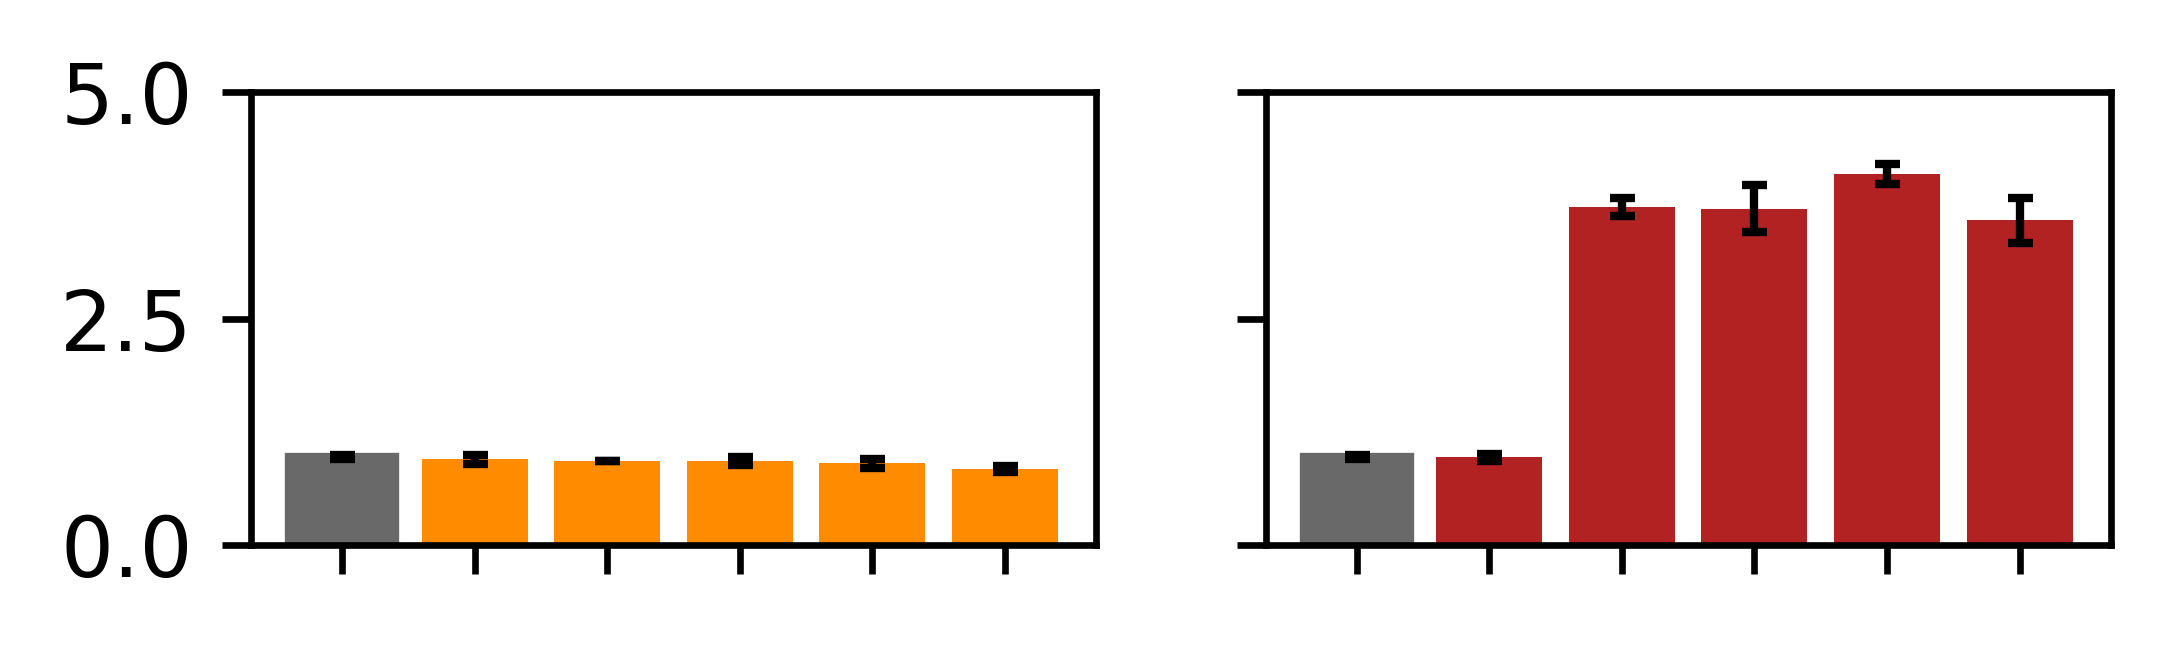

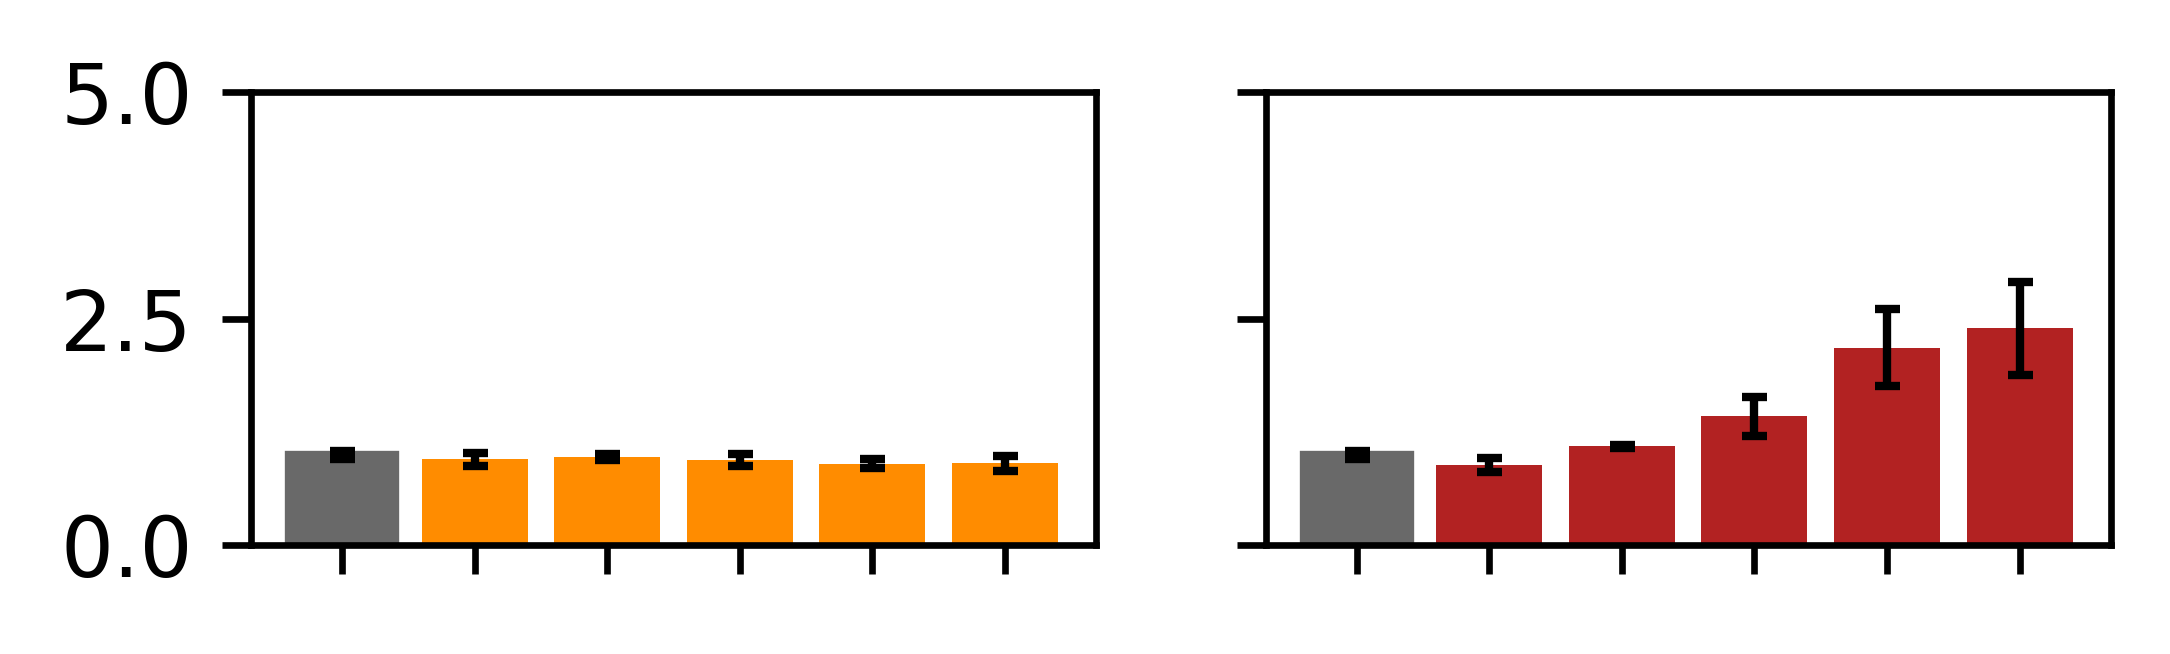

In [5]:
# Plot the data we have
tPoints = [0.0,1.0,2.0,3.0,4.0,5.0]
tPoints = np.reshape(tPoints,[1,6])

for idx,sps in enumerate(spslist):    
    fig = plt.figure(figsize=(4, 1), dpi=600, facecolor='w', edgecolor='k') # dpi=300,         
    ax1 = fig.add_subplot(121)
    barlist1 = plt.bar(tPoints.flatten(), np.reshape(dataEGF[idx,:],[1,6]).flatten(), color='darkorange')
    plt.errorbar(tPoints.flatten(), np.reshape(dataEGF[idx,:],[1,6]).flatten(), 
                 yerr = np.reshape(dataEGFstdfc[idx,:],[1,6])[0], fmt='none', elinewidth=1.0,
                 capsize=1.5, zorder=2, ecolor='black')
    barlist1[0].set_color('dimgrey')
    plt.ylim([0,5])
    plt.xticks(ticks=[0,1,2,3,4,5], labels=[])
    
    ax2 = fig.add_subplot(122)
    barlist2 = plt.bar(tPoints.flatten(), np.reshape(dataEIfn[idx,:],[1,6]).flatten(), color='firebrick')
    plt.errorbar(tPoints.flatten(), np.reshape(dataEIfn[idx,:],[1,6]).flatten(),
                 yerr = np.reshape(dataEIfnstdfc[idx,:],[1,6])[0], fmt='none', elinewidth=1.0,
                 capsize=1.5, zorder=2, ecolor='black')
    barlist2[0].set_color('dimgrey')
    plt.ylim([0,5])
    plt.xticks(ticks=[0,1,2,3,4,5], labels=[])
    plt.yticks(ticks=[0,2.5,5], labels=[])
#     plt.savefig(sps+'_bar.svg', dpi=600, format='svg') # edgecolor='auto', backend=None
    plt.show()

In [6]:
### Run simulations to see the parameter fitting to LINCS data
# The mRNA species we have data for, will plot their trajectories against data
spslistm = ['m_ACSL5','m_BST2','m_CLIC2','m_FAM83D','m_HIST2H2AA3','m_METAP2']
# The protein species we have data for, will plot their trajectories against data
spslist = ['prot_IRF1','prot_CD274']
       
tPoints = np.array([0.0,1.0, 4.0, 8.0, 24.0, 48.0])*3600.0/60.0 # LINCS RPPA data points
tPoints = tPoints.astype(int)
tPoints = tPoints.reshape(1,6)
       
parnames0 = [# IRF1 regulations
             'k4059_5','k4064_5','k4065_5',          
             'k4067_5','k4068_5','k4069_5',
             'k4070_5',
             # PD-L1 regulations
             'k4064_3','k4065_3','k4067_3',          
             'k4068_3','k4069_3','k4071_5',
             # The rest of new TARs
             'k4059_3',
             'k4066_3','k4066_5','k4066_7','k4066_9','k4066_11','k4066_13',
             'k4070_3','k4070_7','k4070_9','k4070_11','k4070_13','k4070_15',
             'k4071_3',
             # kTLs
             'k4064_1',
             'k4065_1',
             'k4067_1',
             'k4225', # kTCd_FAM83D
             'k4068_1',
             'k4069_1',
             'k4071_1',
             'k4066_1',
             'k4070_1']
paravals0 = [50.0,5.5,2.5,
             5.8,1.0,5.8,
             50.0,
             150.0,50.0,150.0,
             50.0,19.0,150.0,
             8.0,
             32.0,2.0,1.0,0.5,10.0,10.0,
             1.7,50.0,50.0,50.0,150.0,1.0,
             200.0,
             0.00042768,
             0.010040722,
             0.00126,
             0.00122,
             0.10754,
             0.0062905,
             0.02217178,
             0.0027585905,
             0.01100385]

### Run to steady state with new parameter values
sys.path.insert(0, os.path.abspath(model_output_dir))
model_module0 = importlib.import_module(model_name)
model0 = model_module0.getModel()
solver0 = model0.getSolver() # Create solver instance
solver0.setMaxSteps = 1e50 
spICs0 = np.array(model0.getInitialStates())
sps_list0 = model0.getStateIds()
th = 1000
for idx,param in enumerate(paravals0):
    model0.setFixedParameterById(parnames0[idx],param)
model0.setInitialStates(spICs0)
model0.setTimepoints(np.linspace(0,th*3600,1001)) # set timepoints ,NSteps+1
rdata_S1MMstst = amici.runAmiciSimulation(model0, solver0) 

### From st.st, run to 24 hrs with IGF only
spICs1 = np.array(rdata_S1MMstst['x'][-1,:])
model_module1 = importlib.import_module(model_name)
model1 = model_module1.getModel()
solver1 = model1.getSolver() # Create solver instance
solver1.setMaxSteps = 1e50 
sps_list1 = model1.getStateIds()
th = 24
IGFdose = 0.02
# EGFdose = 1.5625
# IFNgDose = 1.1834
spICs1[160] = IGFdose # IGF 
for idx,param in enumerate(paravals0):
    model1.setFixedParameterById(parnames0[idx],param)
model1.setInitialStates(spICs1)
model1.setTimepoints(np.linspace(0,th*3600,1001)) # set timepoints ,NSteps+1
rdata_S1MM_IGF24 = amici.runAmiciSimulation(model1, solver1) 

### From IGF 24 hr, run to 48 hrs with EGF only
spICs2 = np.array(rdata_S1MM_IGF24['x'][-1,:])
model_module2 = importlib.import_module(model_name)
model2 = model_module2.getModel()
solver2 = model2.getSolver() # Create solver instance
solver2.setMaxSteps = 1e50 
sps_list2 = model2.getStateIds()
th = 48
IGFdose = 0.02
EGFdose = 1.5625
IFNgDose = 1.1834
spICs2[160] = IGFdose # IGF 
spICs2[155] = EGFdose # EGF 
for idx,param in enumerate(paravals0):
    model2.setFixedParameterById(parnames0[idx],param)
model2.setInitialStates(spICs2)
model2.setTimepoints(np.linspace(0,th*3600,2881)) # set timepoints ,NSteps+1
rdata_S1MM_48hrE = amici.runAmiciSimulation(model2, solver2) 

### From st.st, run to 48 hrs with EGF+IFNG
spICs3 = np.array(rdata_S1MM_IGF24['x'][-1,:])
model_module3 = importlib.import_module(model_name)
model3 = model_module3.getModel()
solver3 = model3.getSolver() # Create solver instance
solver3.setMaxSteps = 1e50 
sps_list3 = model3.getStateIds()
n_sp = len(sps_list3)
th = 48
IGFdose = 0.02
EGFdose = 1.5625
IFNgDose = 1.1834
spICs3[160] = IGFdose # IGF 
spICs3[155] = EGFdose # EGF 
spICs3[801] = IFNgDose # IFNg 
for idx,param in enumerate(paravals0):
    model3.setFixedParameterById(parnames0[idx],param)
model3.setInitialStates(spICs3)
model3.setTimepoints(np.linspace(0,th*3600,2881)) # set timepoints ,NSteps+1
rdata_S1MM_48hrEIfn = amici.runAmiciSimulation(model3, solver3)

In [7]:
# pltList = (['m_ACSL5','prot_ACSL5',
#             'm_BST2','prot_BST2',
#             'm_CLIC2','prot_CLIC2',
#             'm_FAM83D','prot_FAM83D',
#             'm_HIST2H2AA3','prot_HIST2H2AA3',
#             'm_METAP2','prot_METAP2', 
#             'm_STAT1','STAT1', 'STAT1snuc_STAT1snuc',
#             'm_SOCS1','SOCS1', 
#             'm_IRF1','prot_IRF1',
#             'm_CD274','prot_CD274'])

# for idx,sps in enumerate(pltList):    
#     fig = plt.figure(figsize=(6, 1), dpi=100, facecolor='w', edgecolor='k')
#     ax1 = fig.add_subplot(121)
#     plt.plot(rdata_S1MMstst['t']/3600.0, rdata_S1MMstst['x'][:,sps_list1.index(sps)], 'k')
#     ax1.set_ylabel(sps)
#     plt.xlim([-100,(rdata_S1MMstst['t'][-1]/3600.0)+1]) 
#     ax2 = fig.add_subplot(122)
#     plt.plot(rdata_S1MM_48hrE['t']/3600.0, rdata_S1MM_48hrE['x'][:,sps_list2.index(sps)], 'k')
#     plt.plot(rdata_S1MM_48hrEIfn['t']/3600.0, rdata_S1MM_48hrEIfn['x'][:,sps_list3.index(sps)], 'm:')
#     plt.xlim([-1,th+1])
#     plt.show()

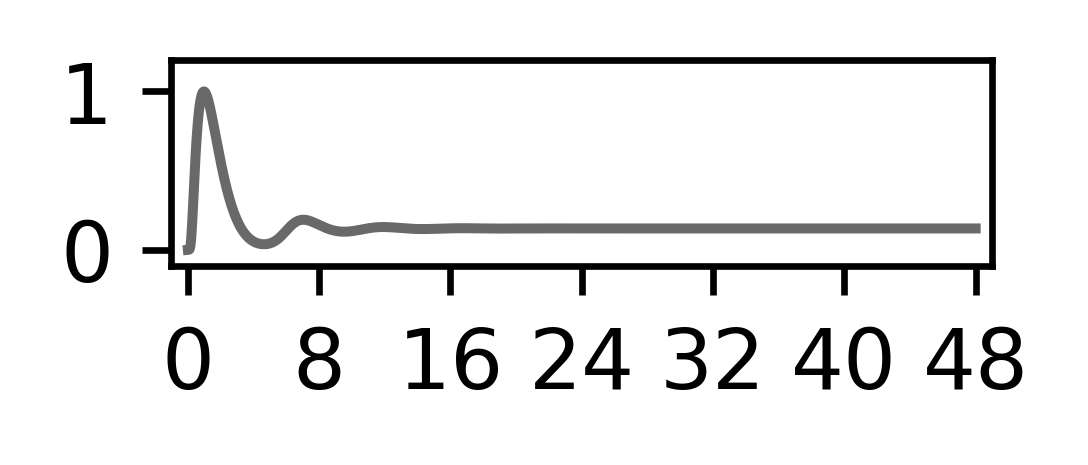

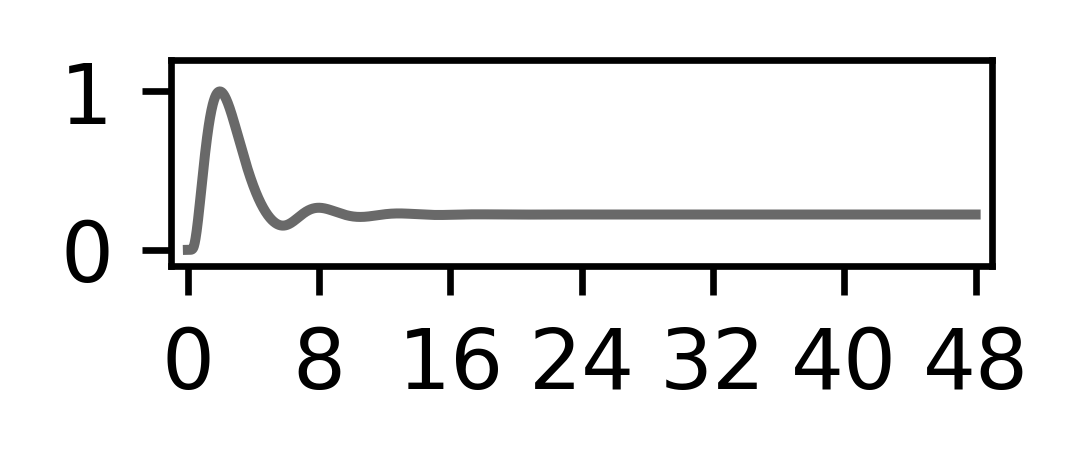

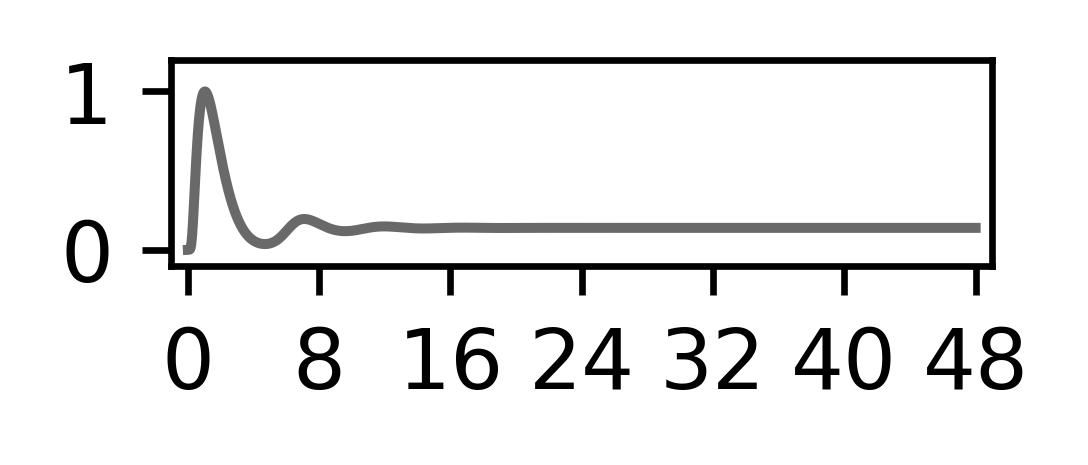

In [8]:
### Make sure MEMMAL expansion did not mess-up SPARCED-IFNG model responses
spslistplt = ['STAT1snuc_STAT1snuc','SOCS1','m_SOCS1']
ylimMaxs = [30,8,15,3,5,2]
for idx,sps in enumerate(spslistplt):  
    fig = plt.figure(figsize=(6, 1), dpi=600, facecolor='w', edgecolor='k') # dpi=300,         
    ax1 = fig.add_subplot(231)
    aaa = (rdata_S1MM_48hrEIfn['x'][:,sps_list3.index(sps)]).flatten()
    bbb = aaa/aaa.max()
    plt.plot(rdata_S1MM_48hrEIfn['t']/3600.0, bbb, 'dimgrey', linewidth=1.2)
    plt.xlim([-1,th+1])
    plt.ylim([-0.1,1.2])   
    plt.xticks(np.arange(0, th+1, step=8)) 
#     plt.savefig(sps+'.svg', dpi=600, format='svg') # edgecolor='auto', backend=None
    plt.show()

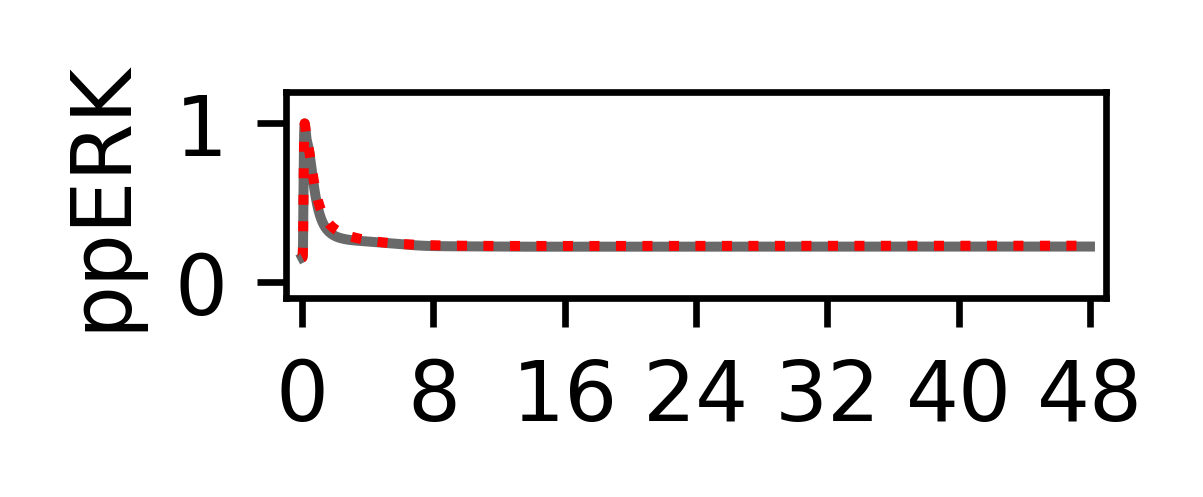

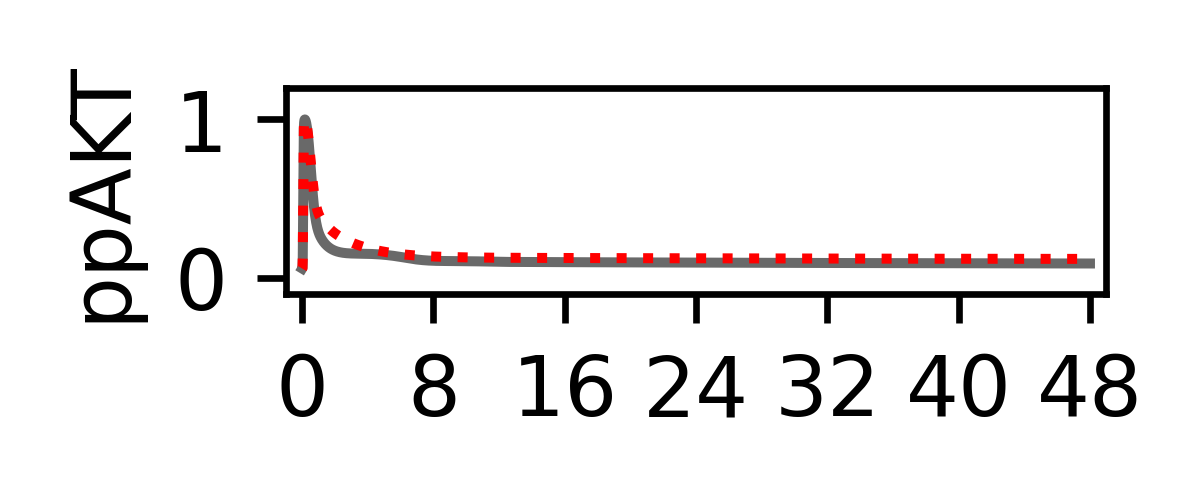

In [9]:
### Make sure MEMMAL expansion did not mess-up SPARCED-IFNG model responses
spslistplt = ['ppERK','ppAKT']
for idx,sps in enumerate(spslistplt):  
    fig = plt.figure(figsize=(6, 1), dpi=600, facecolor='w', edgecolor='k') # dpi=300,         
    ax1 = fig.add_subplot(231)
    aaa = (rdata_S1MM_48hrEIfn['x'][:,sps_list3.index(sps)]).flatten()
    bbb = aaa/aaa.max()
    plt.plot(rdata_S1MM_48hrEIfn['t']/3600.0, bbb, 'dimgrey', linewidth=1.2)
    
    ccc = (rdata_S1MM_48hrE['x'][:,sps_list3.index(sps)]).flatten()
    ddd = ccc/ccc.max()
    plt.plot(rdata_S1MM_48hrE['t']/3600.0, ddd, 'r:', linewidth=1.2)
    ax1.set_ylabel(sps)
    plt.xlim([-1,th+1])
    plt.ylim([-0.1,1.2])   
    plt.xticks(np.arange(0, th+1, step=8)) 
#     plt.savefig(sps+'.svg', dpi=600, format='svg') # edgecolor='auto', backend=None
    plt.show()

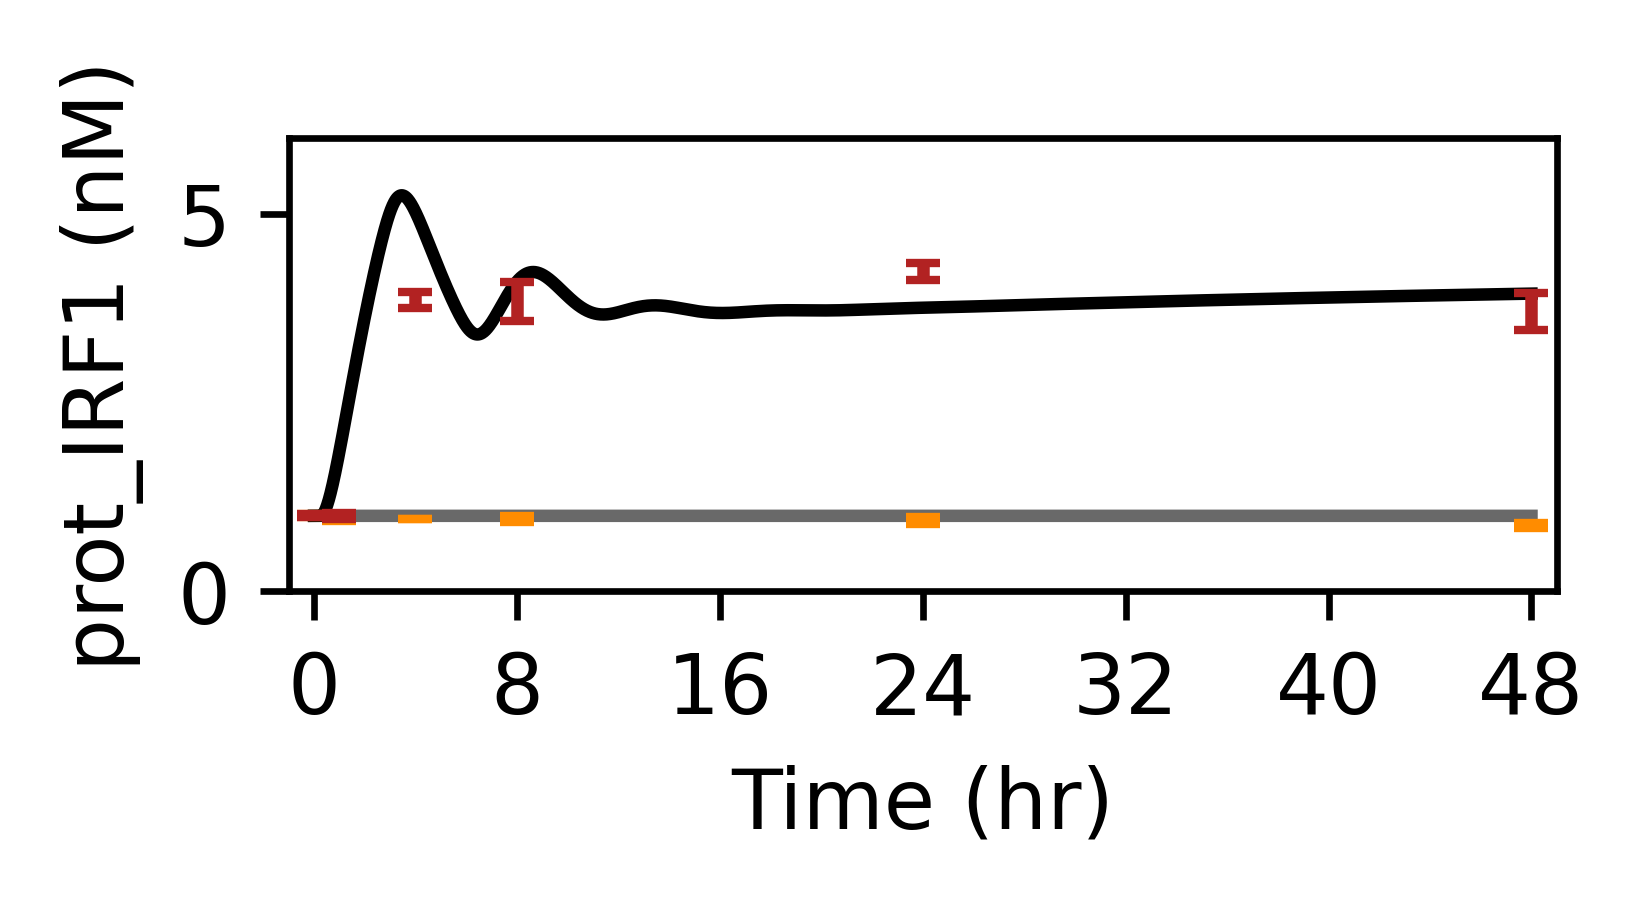

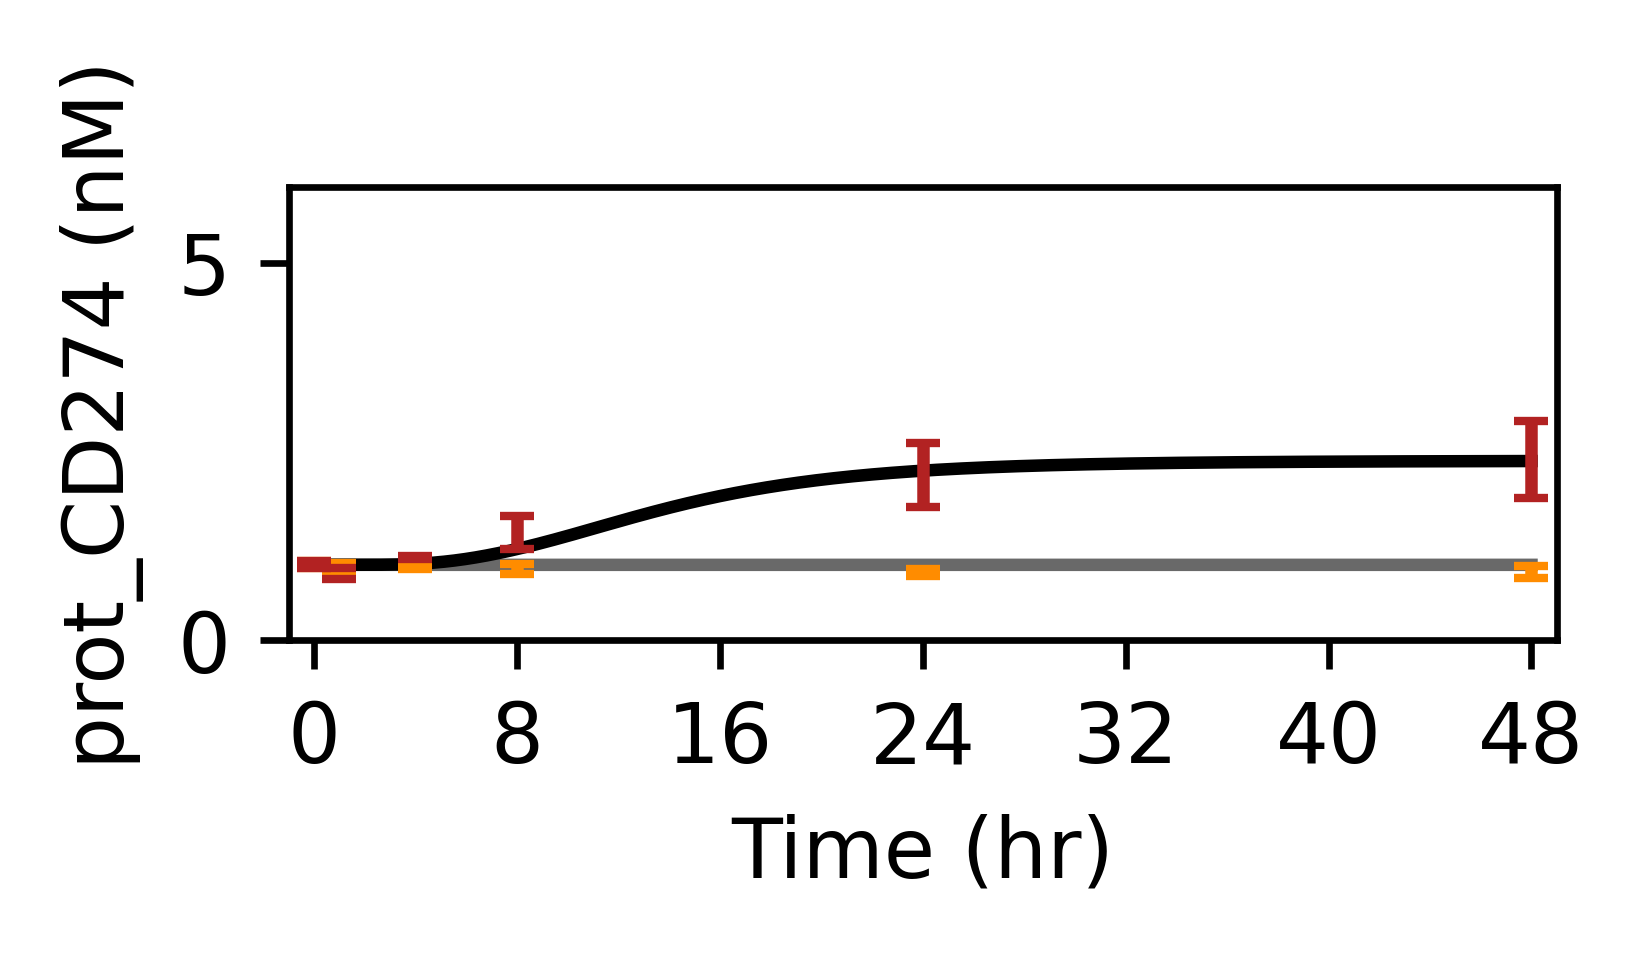

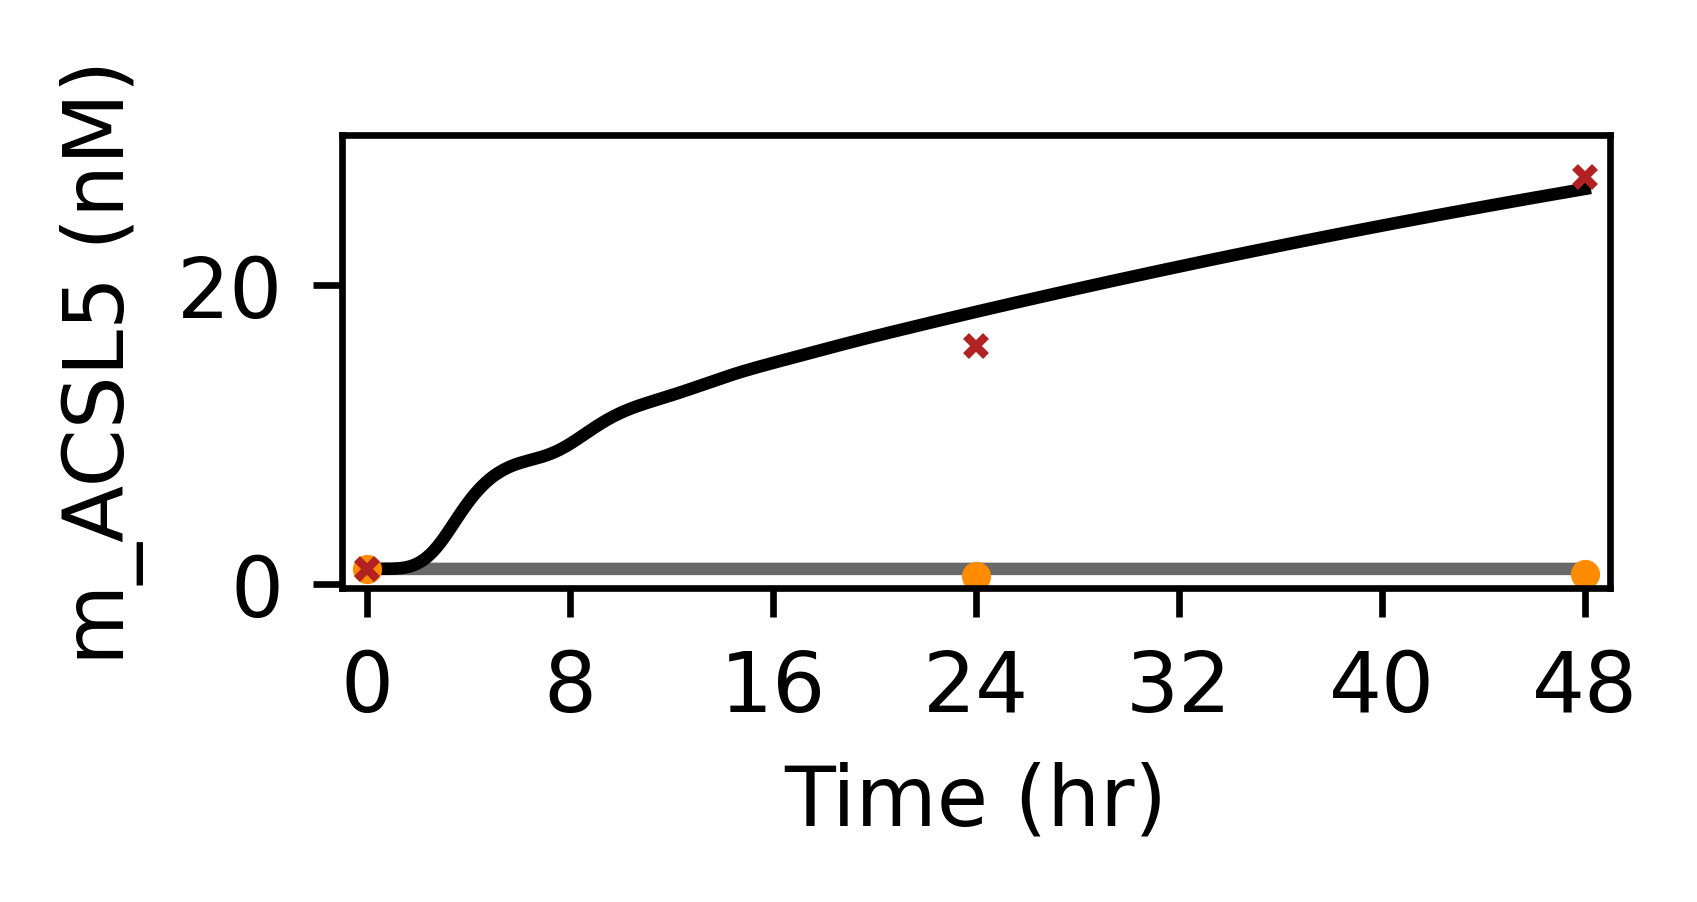

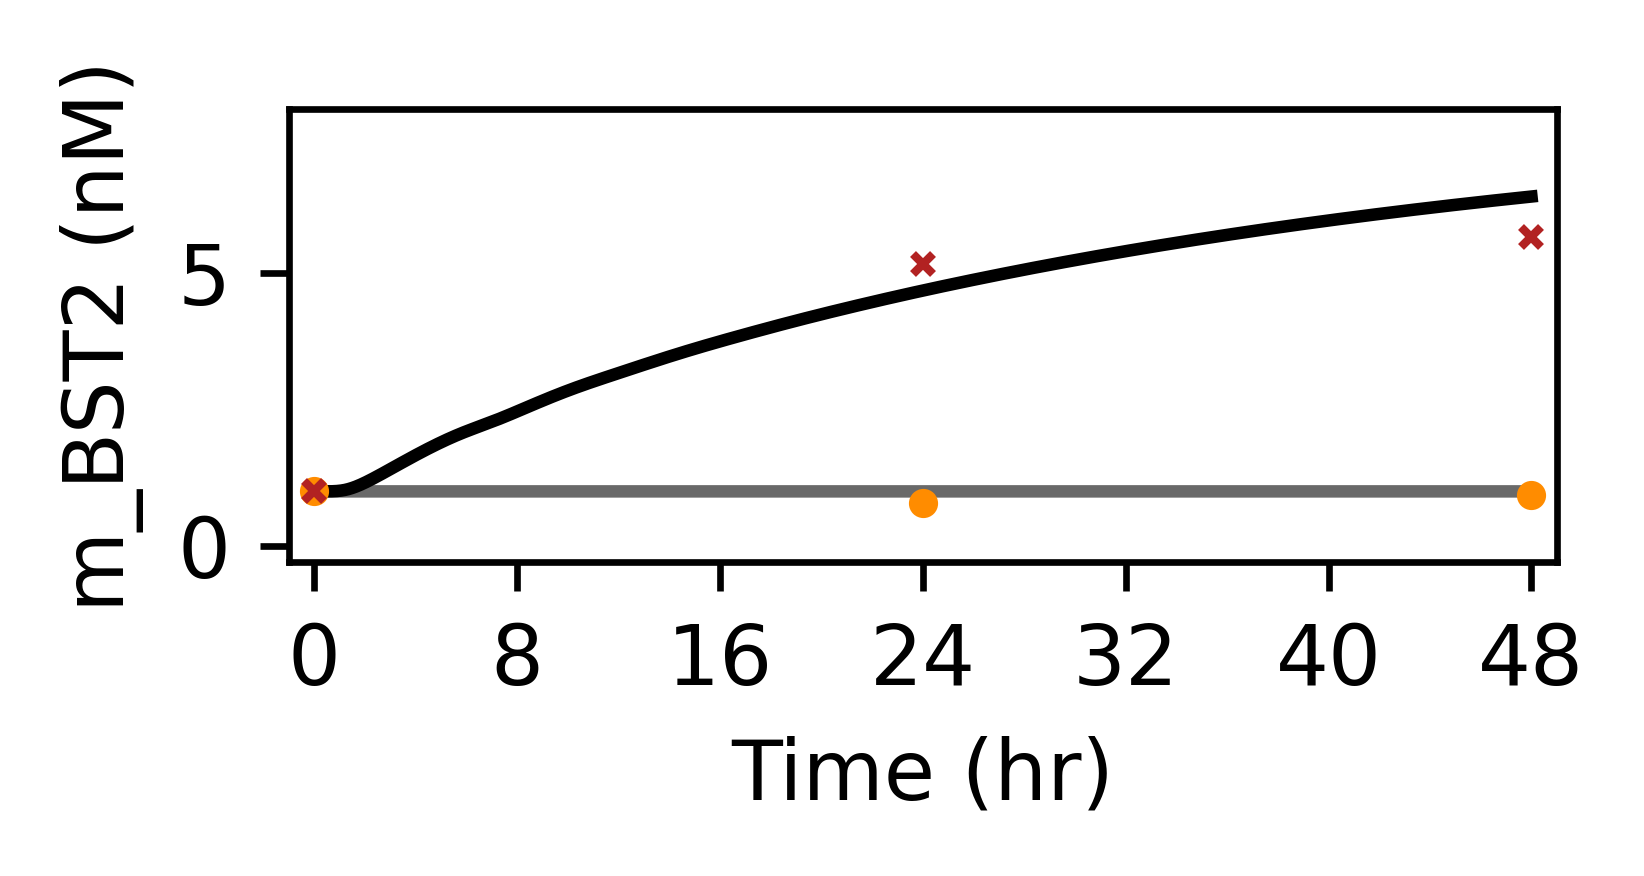

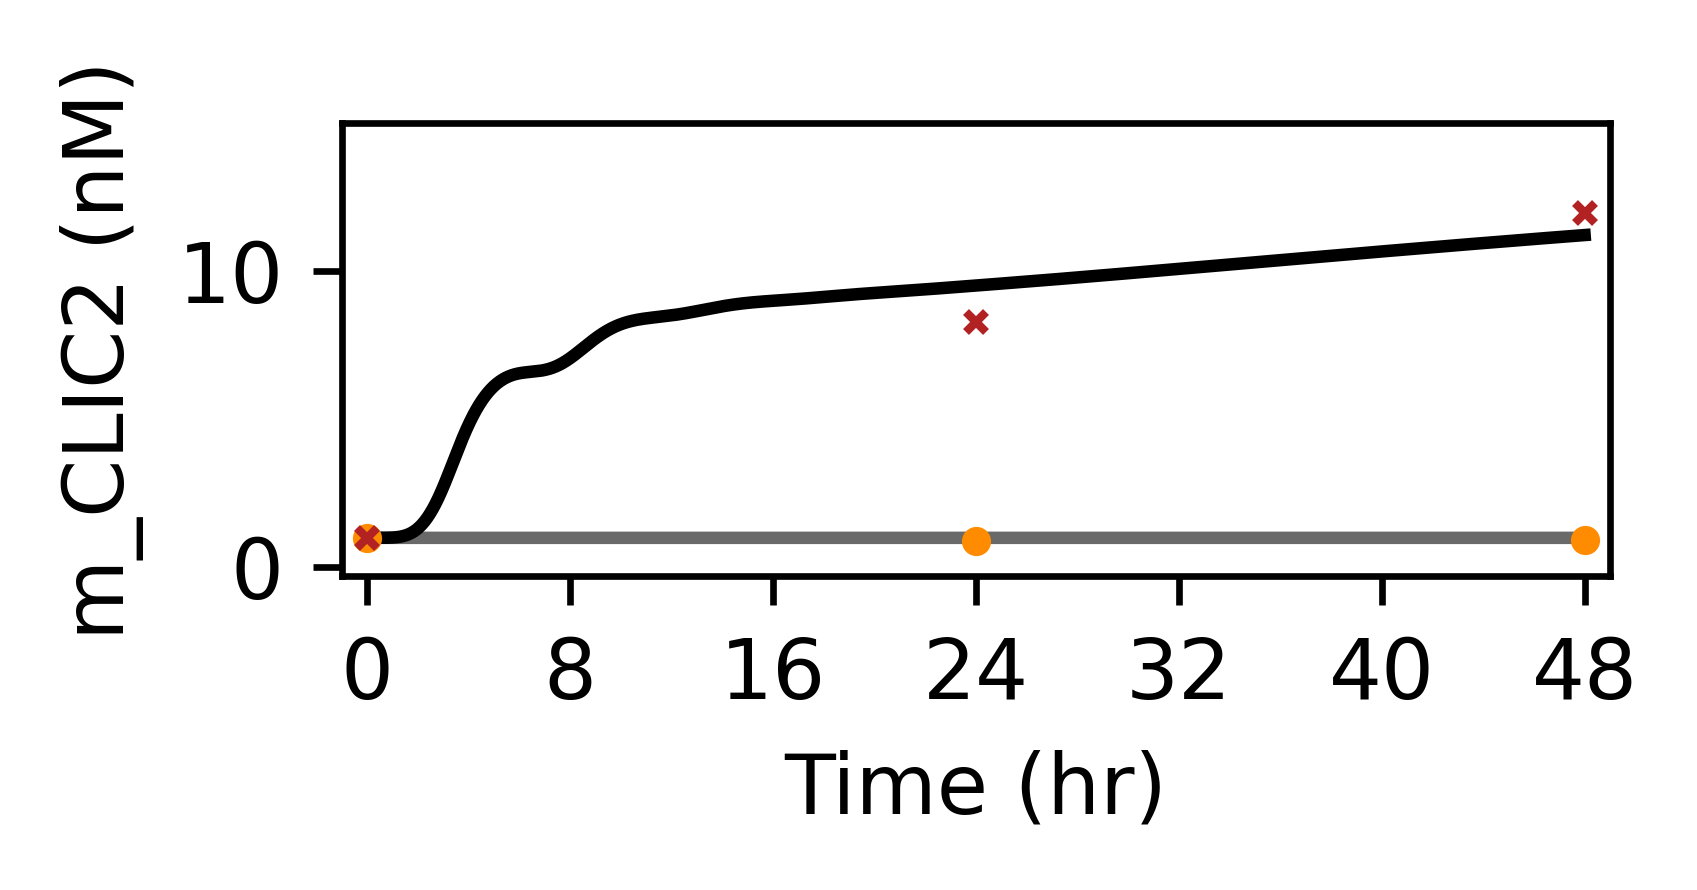

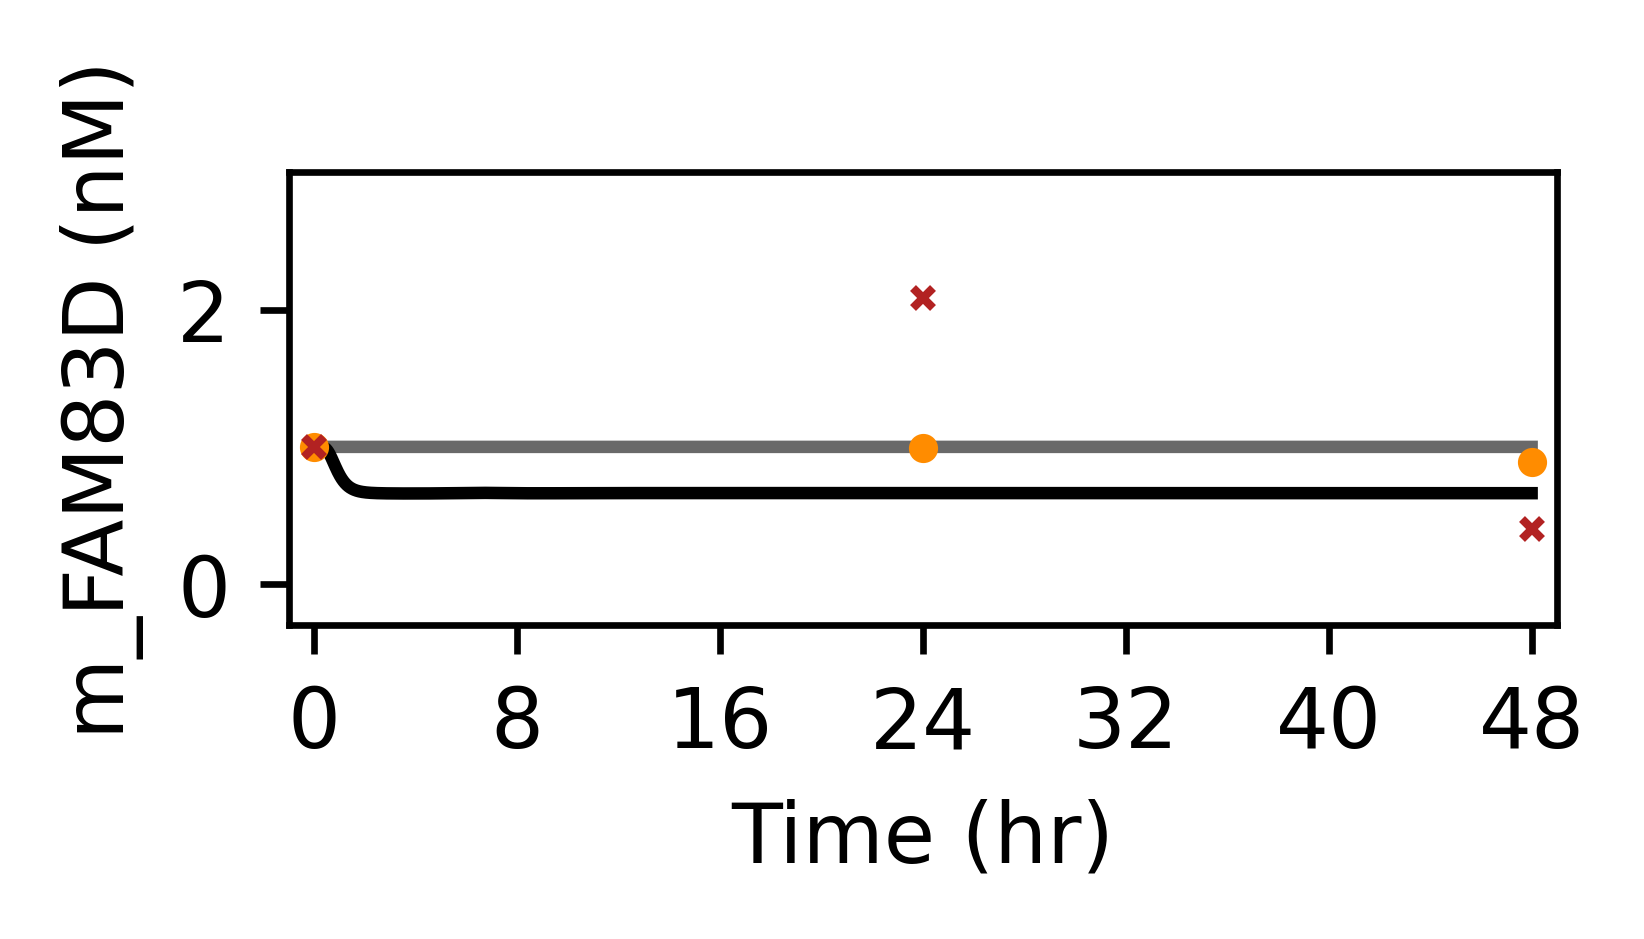

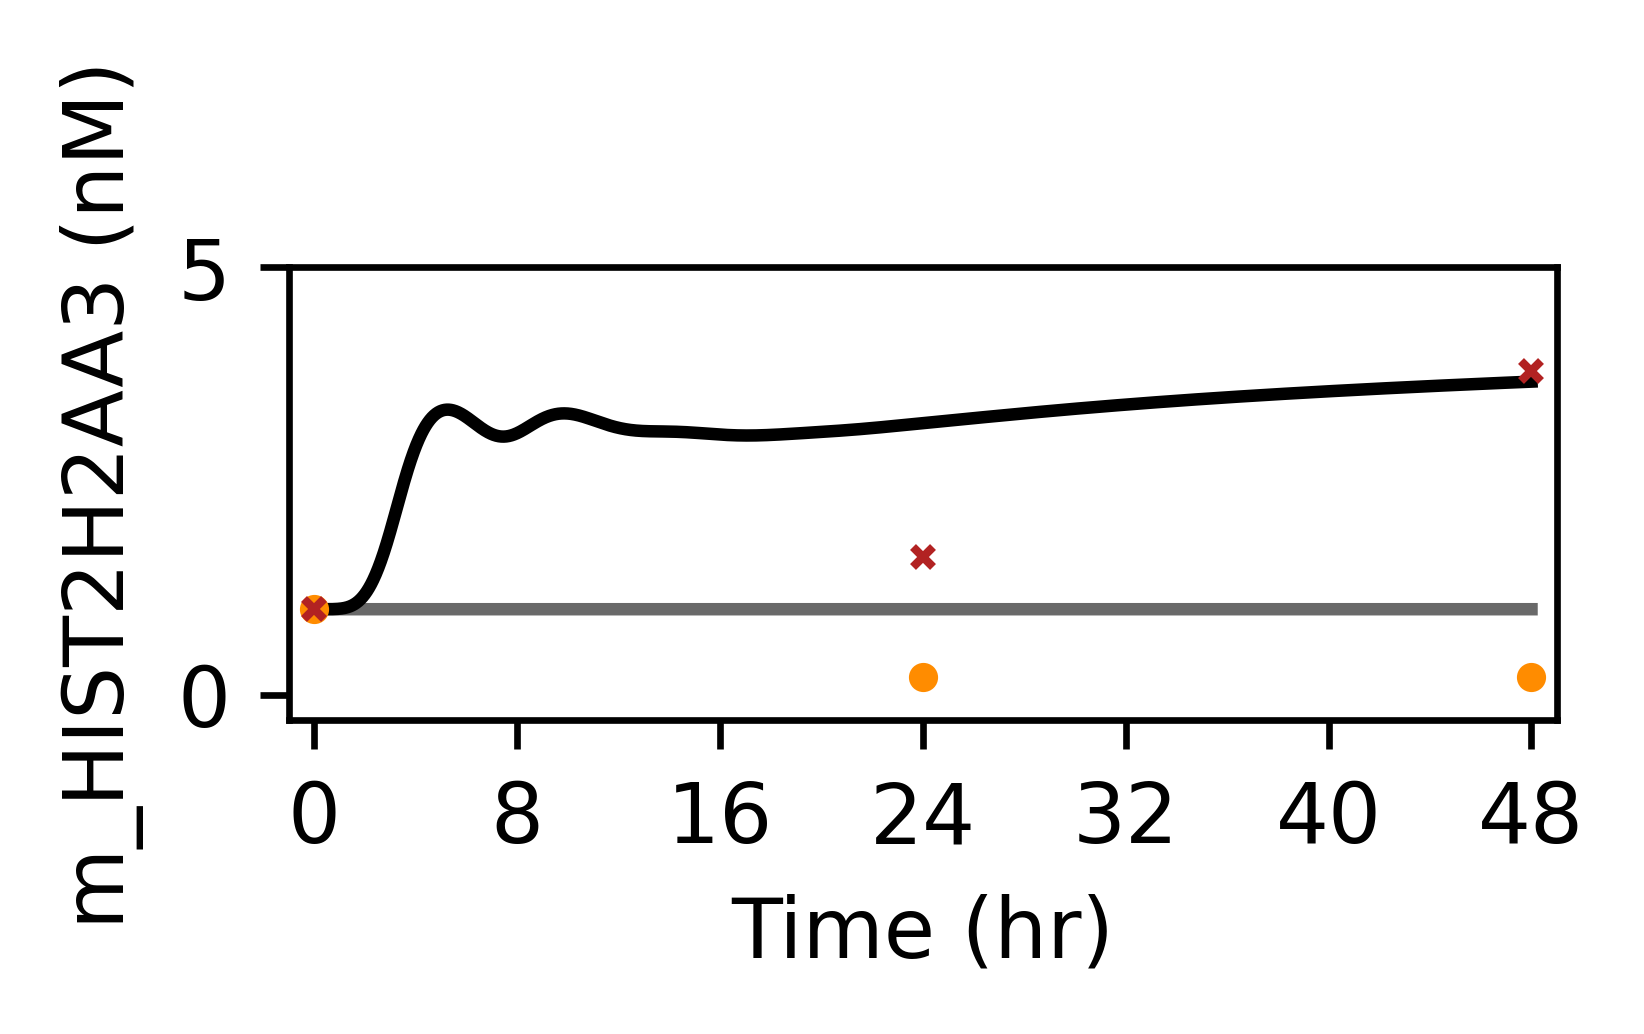

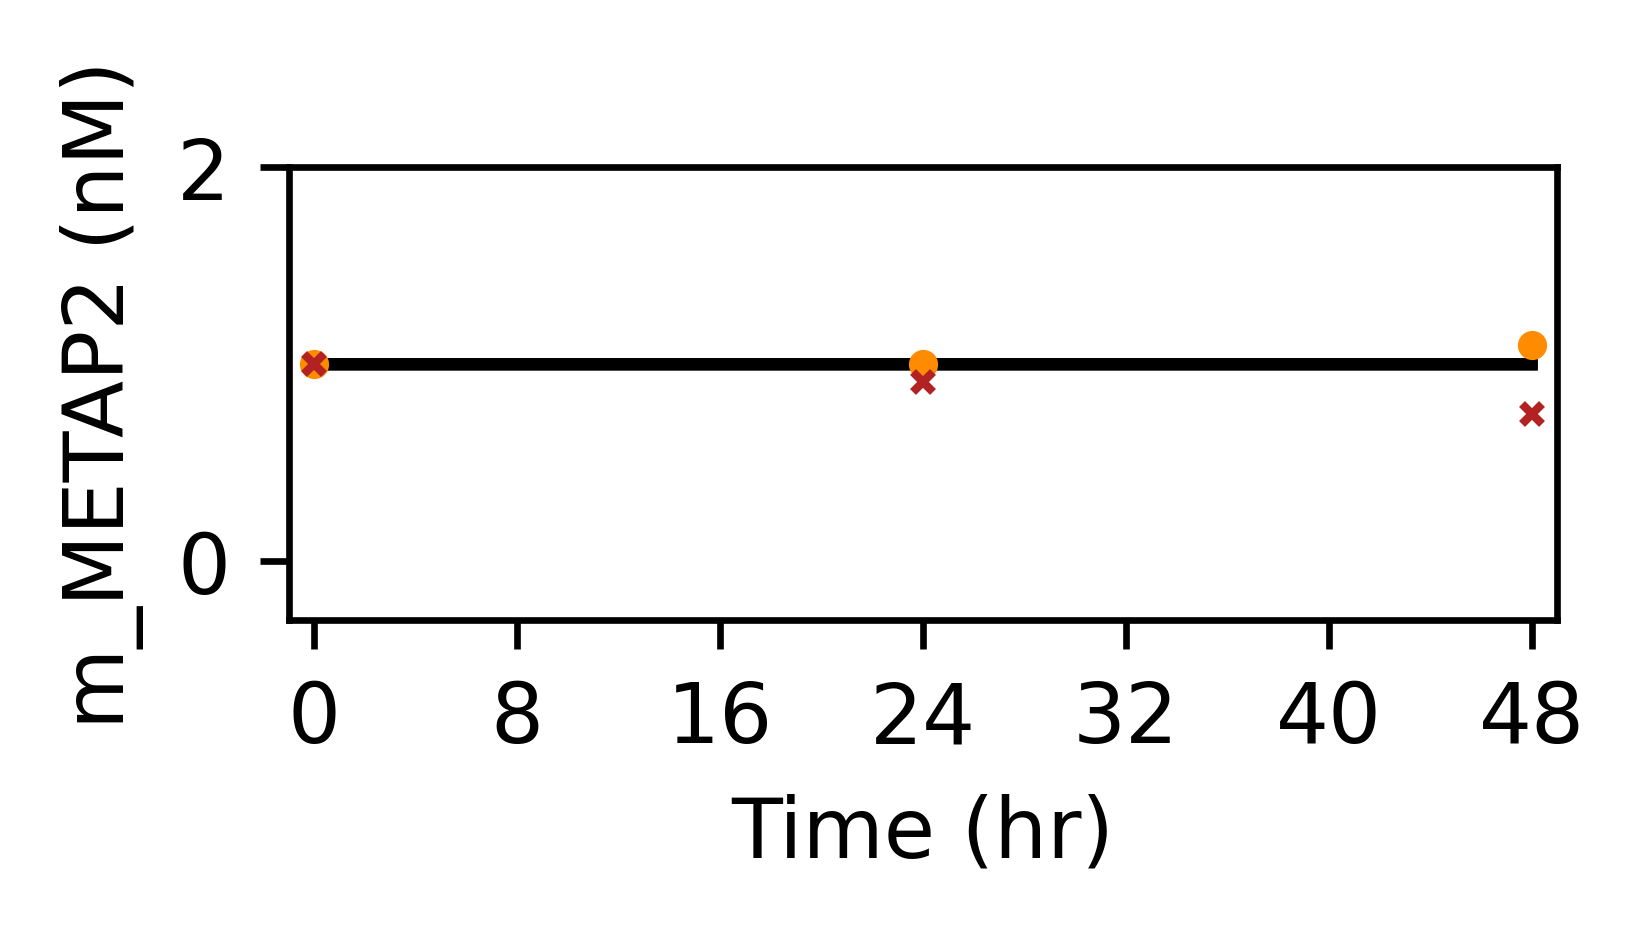

In [11]:
### Plot protein and mRNA levels for the species we have data for
tPoints = [0.0,1.0,4.0,8.0,24.0,48.0]
tPoints = np.reshape(tPoints,[1,6])

mtPoints = [0.0,24.0,48.0]
mtPoints = np.reshape(mtPoints,[1,3])

for idx,sps in enumerate(spslist):    
    fig = plt.figure(figsize=(6, 1), dpi=600, facecolor='w', edgecolor='k') # dpi=300,         
    ax1 = fig.add_subplot(121)
    plt.errorbar(tPoints.flatten(), np.reshape(dataEGFfc[idx,:],[1,6]).flatten(), 
                 yerr = np.reshape(dataEGFstdfc[idx,:],[1,6])[0], fmt='none', elinewidth=1.5,
                 capsize=2, zorder=2, ecolor='darkorange')
    aaa = rdata_S1MM_48hrE['x'][:,sps_list2.index(sps)]
    plt.plot(rdata_S1MM_48hrE['t']/3600.0, aaa/aaa[0] , 'dimgrey', zorder=1) 

    plt.errorbar(tPoints.flatten(), np.reshape(dataEIfnfc[idx,:],[1,6]).flatten(),
                 yerr = np.reshape(dataEIfnstdfc[idx,:],[1,6])[0], fmt='none', elinewidth=1.5,
                 capsize=2, zorder=2, ecolor='firebrick')
    bbb = rdata_S1MM_48hrEIfn['x'][:,sps_list3.index(sps)]
    plt.plot(rdata_S1MM_48hrEIfn['t']/3600.0, bbb/bbb[0], 'k', zorder=1)
    plt.xlim([-1,th+1])
    plt.ylim([0,6])
    plt.xticks(np.arange(0, th+1, step=8))  
    ax1.set_ylabel(sps+' (nM)')
    ax1.set_xlabel('Time (hr)')
    ax1.ticklabel_format(useOffset=False)
#     plt.savefig(sps+'.svg', dpi=600, format='svg') # edgecolor='auto', backend=None
    plt.show()

ylimMaxs = [30,8,15,3,5,2]
for idx,sps in enumerate(spslistm):  
    fig = plt.figure(figsize=(6, 1), dpi=600, facecolor='w', edgecolor='k') # dpi=300,         
    ax1 = fig.add_subplot(121)
    plt.plot(mtPoints, np.reshape(mdataEGFfc[idx,:],[1,3]), 'darkorange', marker='o', markersize=2.5, zorder=2)
    aaa = (rdata_S1MM_48hrE['x'][:,sps_list2.index(sps)]).flatten()
    bbb = aaa/aaa[0]
    plt.plot(rdata_S1MM_48hrE['t']/3600.0, bbb, 'dimgrey', zorder=1)

    plt.plot(mtPoints, np.reshape(mdataEIfnfc[idx,:],[1,3]), 'firebrick', marker='x', markersize=2.5, zorder=2)
    ccc = (rdata_S1MM_48hrEIfn['x'][:,sps_list3.index(sps)]).flatten()
    ddd = ccc/ccc[0]
    plt.plot(rdata_S1MM_48hrEIfn['t']/3600.0, ddd, 'k', zorder=1)
    plt.xticks(np.arange(0, th+1, step=8))  
    ax1.set_ylabel(sps+' (nM)')
    ax1.set_xlabel('Time (hr)')
    ax1.ticklabel_format(useOffset=False)
    plt.xlim([-1,th+1])
    plt.ylim([-0.3,ylimMaxs[idx]])   
#     plt.savefig(sps+'.svg', dpi=600, format='svg') # edgecolor='auto', backend=None
    plt.show()

## Simulate wild-type

In [12]:
### Input files and model from above, re-define if necessary

parnames0 = ['k4059_5','k4064_5','k4065_5',          
             'k4067_5','k4068_5','k4069_5',
             'k4070_5',
             'k4064_3','k4065_3','k4067_3',          
             'k4068_3','k4069_3','k4071_5',
             'k4059_3',
             'k4066_3','k4066_5','k4066_7','k4066_9','k4066_11','k4066_13',
             'k4070_3','k4070_7','k4070_9','k4070_11','k4070_13','k4070_15',
             'k4071_3',
             'k4064_1',
             'k4065_1',
             'k4067_1',
             'k4225',
             'k4068_1',
             'k4069_1',
             'k4071_1',
             'k4066_1',
             'k4070_1']
paravals0 = [50.0,5.5,2.5,
             5.8,1.0,5.8,
             50.0,
             150.0,50.0,150.0,
             50.0,19.0,150.0,
             8.0,
             32.0,2.0,1.0,0.5,10.0,10.0,
             1.7,50.0,50.0,50.0,150.0,1.0,
             200.0,
             0.00042768,
             0.010040722,
             0.00126,
             0.00122,
             0.10754,
             0.0062905,
             0.02217178,
             0.0027585905,
             0.01100385]

### Run to steady state with FITTED parameters
sys.path.insert(0, os.path.abspath(model_output_dir))
model_module0 = importlib.import_module(model_name)
model0 = model_module0.getModel()
solver0 = model0.getSolver() # Create solver instance
solver0.setMaxSteps = 1e50 
spICs0 = np.array(model0.getInitialStates())
sps_list0 = model0.getStateIds()
th = 1000
for idx,param in enumerate(paravals0):
    model0.setFixedParameterById(parnames0[idx],param)
model0.setInitialStates(spICs0)
model0.setTimepoints(np.linspace(0,th*3600,1001)) # set timepoints ,NSteps+1
rdata_S1MMstst = amici.runAmiciSimulation(model0, solver0) 

### Wild-type simulations: (1) from st.st, run to 24 hrs with IGF only
spICs1 = np.array(rdata_S1MMstst['x'][-1,:])
model_module1 = importlib.import_module(model_name)
model1 = model_module1.getModel()
solver1 = model1.getSolver() # Create solver instance
solver1.setMaxSteps = 1e50 
sps_list1 = model1.getStateIds()
th = 24
IGFdose = 0.02
EGFdose = 1.5625
IFNgDose = 1.1834
spICs1[160] = IGFdose # IGF 
for idx,param in enumerate(paravals0):
    model1.setFixedParameterById(parnames0[idx],param)
model1.setInitialStates(spICs1)
model1.setTimepoints(np.linspace(0,th*3600,1001)) # set timepoints ,NSteps+1
rdata_S1MM_IGF24 = amici.runAmiciSimulation(model1, solver1) 

### (2) From st.st, run to 48 hrs with EGF+IFNG
spICs3 = np.array(rdata_S1MM_IGF24['x'][-1,:])
model_module3 = importlib.import_module(model_name)
model3 = model_module3.getModel()
solver3 = model3.getSolver() # Create solver instance
solver3.setMaxSteps = 1e50 
sps_list3 = model3.getStateIds()
n_sp = len(sps_list3)
th = 48
IGFdose = 0.02
EGFdose = 1.5625
IFNgDose = 1.1834
spICs3[160] = IGFdose # IGF 
spICs3[155] = EGFdose # EGF 
spICs3[801] = IFNgDose # IFNg 
for idx,param in enumerate(paravals0):
    model3.setFixedParameterById(parnames0[idx],param)
model3.setInitialStates(spICs3)
model3.setTimepoints(np.linspace(0,th*3600,2881)) # set timepoints ,NSteps+1
rdata_S1MM_48hrEIfnWT = amici.runAmiciSimulation(model3, solver3)

## Now, simulate complete knock-out scenario and compare

ACSL5


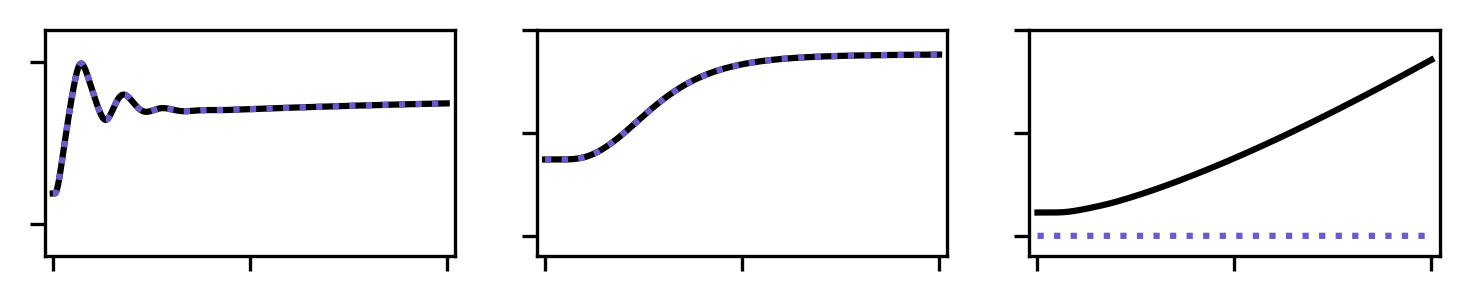

BST2


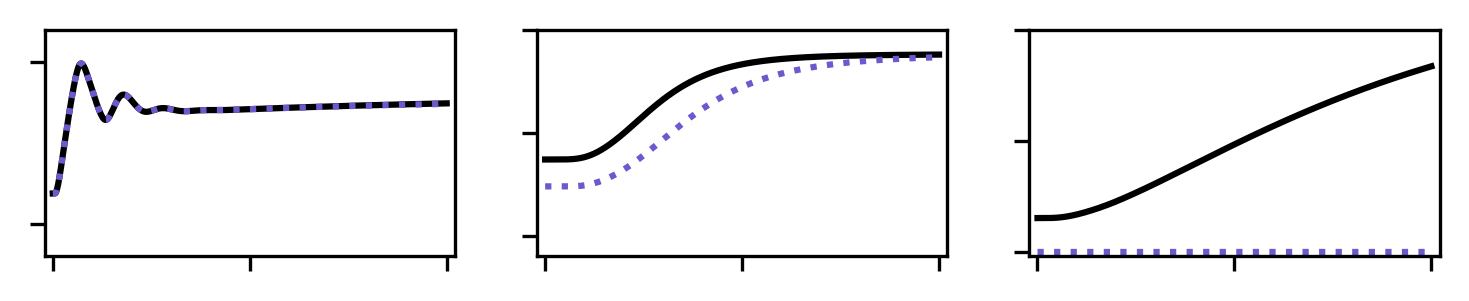

CLIC2


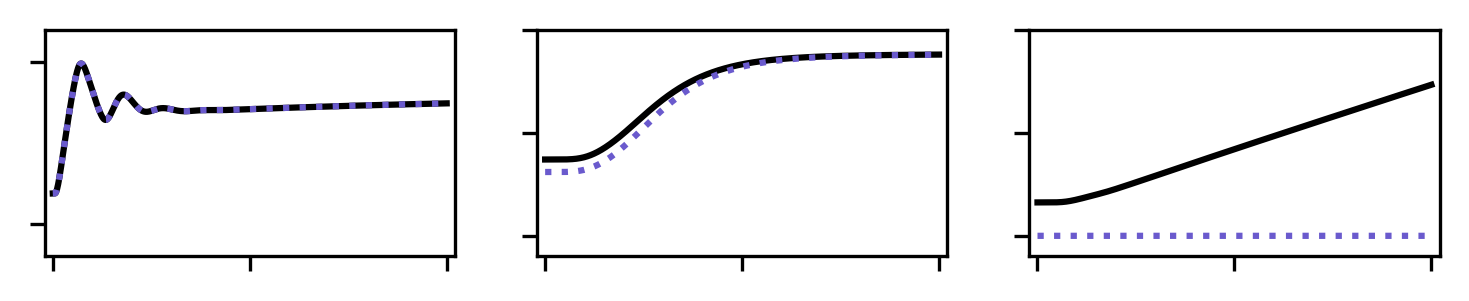

FAM83D


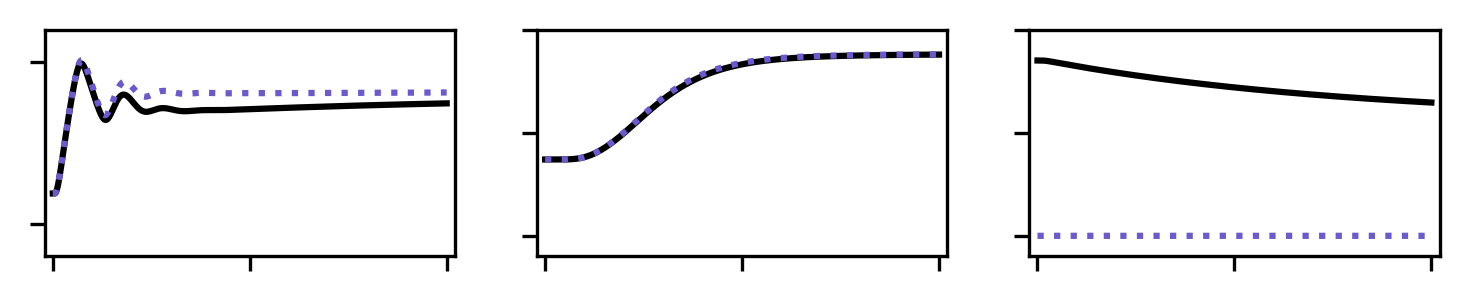

HIST2H2AA3


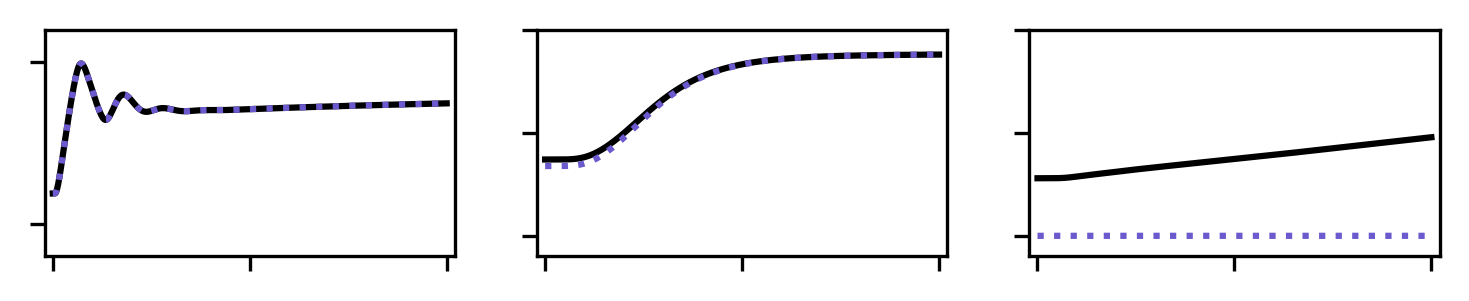

METAP2


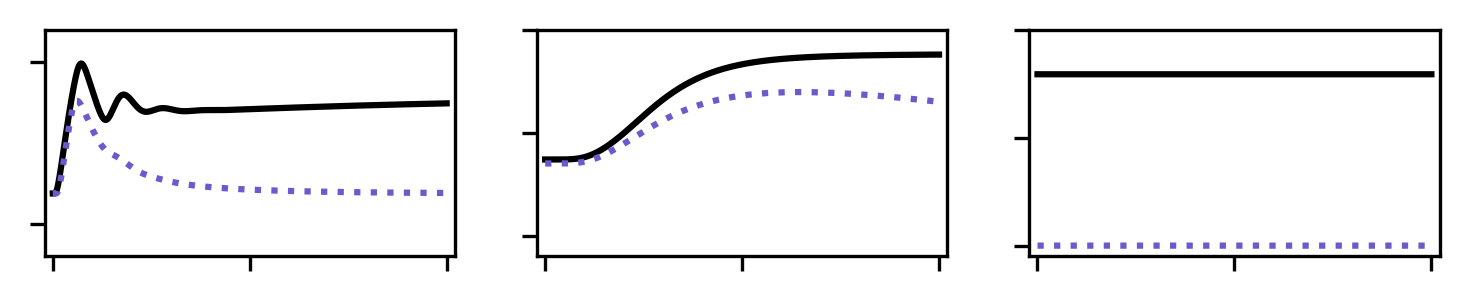

In [13]:
geneNames = ['ACSL5','BST2','CLIC2','FAM83D','HIST2H2AA3','METAP2']
parnames = ['k4221','k4222','k4224','k4225','k4226','k4228']

for idxg,gene in enumerate(geneNames):
    sp1 = 'ag_'+gene
    sp2 = 'ig_'+gene
    sppr = 'prot_'+gene
    spmr = 'm_'+gene
    spICs1 = np.array(rdata_S1MMstst['x'][-1,:])
    model_module1 = importlib.import_module(model_name)
    model1 = model_module1.getModel()
    solver1 = model1.getSolver() # Create solver instance
    solver1.setMaxSteps = 1e50 
    sps_list1 = model1.getStateIds()
    th = 24
    IGFdose = 0.02
    EGFdose = 1.5625
    IFNgDose = 1.1834
    spICs1[160] = IGFdose # IGF  
    parval = model1.getFixedParameterById(parnames[idxg])
    model1.setFixedParameterById(parnames[idxg],100.0*parval)
    for idx,param in enumerate(paravals0):
        model1.setFixedParameterById(parnames0[idx],param)
    spICs1[sps_list1.index(sp1)] = 0.0
    spICs1[sps_list1.index(sp2)] = 0.0
    spICs1[sps_list1.index(sppr)] = 0.0
    spICs1[sps_list1.index(spmr)] = 0.0
    model1.setInitialStates(spICs1)
    model1.setTimepoints(np.linspace(0,th*3600,1001)) # set timepoints ,NSteps+1
    rdata_S1MM_IGF24 = amici.runAmiciSimulation(model1, solver1) 

    ### From st.st, run to 48 hrs with EGF+IFNG
    spICs3 = np.array(rdata_S1MM_IGF24['x'][-1,:])
    model_module3 = importlib.import_module(model_name)
    model3 = model_module3.getModel()
    solver3 = model3.getSolver() # Create solver instance
    solver3.setMaxSteps = 1e50 
    sps_list3 = model3.getStateIds()
    n_sp = len(sps_list3)
    th = 48
    IGFdose = 0.02
    EGFdose = 1.5625
    IFNgDose = 1.1834
    spICs3[160] = IGFdose # IGF 
    spICs3[155] = EGFdose # EGF 
    spICs3[801] = IFNgDose # IFNg 
    parval = model3.getFixedParameterById(parnames[idxg])
    model3.setFixedParameterById(parnames[idxg],100.0*parval)
    for idx,param in enumerate(paravals0):
        model3.setFixedParameterById(parnames0[idx],param)
    spICs3[sps_list3.index(sp1)] = 0.0
    spICs3[sps_list3.index(sp2)] = 0.0
    spICs3[sps_list3.index(sppr)] = 0.0
    spICs3[sps_list3.index(spmr)] = 0.0
    model3.setInitialStates(spICs3)
    model3.setTimepoints(np.linspace(0,th*3600,2881)) # set timepoints ,NSteps+1
    rdata_S1MM_48hrEIfn = amici.runAmiciSimulation(model3, solver3)

    pltList = (['prot_IRF1','prot_CD274'])
    ylimMaxs3 = [3,50,2,1,2,20]
    ylimMins3 = [-0.3,-1,-0.2,-0.1,-0.2,-1]
    print(gene)
    fig = plt.figure(figsize=(6, 1), dpi=300, facecolor='w', edgecolor='k') #  
    ax1 = fig.add_subplot(131)
    plt.plot(rdata_S1MM_48hrEIfnWT['t']/3600.0, rdata_S1MM_48hrEIfnWT['x'][:,sps_list3.index(pltList[0])], 'k')
    plt.plot(rdata_S1MM_48hrEIfn['t']/3600.0, rdata_S1MM_48hrEIfn['x'][:,sps_list3.index(pltList[0])], 'slateblue',linestyle=':')
    plt.xlim([-1,th+1])
    plt.ylim([-1,6])
    plt.yticks(ticks=[0,5], labels=[])
    plt.xticks(ticks=[0,24,48], labels=[])
    
    ax2 = fig.add_subplot(132)
    plt.plot(rdata_S1MM_48hrEIfnWT['t']/3600.0, rdata_S1MM_48hrEIfnWT['x'][:,sps_list3.index(pltList[1])], 'k')
    plt.plot(rdata_S1MM_48hrEIfn['t']/3600.0, rdata_S1MM_48hrEIfn['x'][:,sps_list3.index(pltList[1])], 'slateblue',linestyle=':')
    plt.xlim([-1,th+1])
    plt.ylim([-1,10])
    plt.yticks(ticks=[0,5,10], labels=[])
    plt.xticks(ticks=[0,24,48], labels=[])
    
    ax3 = fig.add_subplot(133)
    plt.plot(rdata_S1MM_48hrEIfnWT['t']/3600.0, rdata_S1MM_48hrEIfnWT['x'][:,sps_list3.index('prot_'+gene)], 'k')
    plt.plot(rdata_S1MM_48hrEIfn['t']/3600.0, rdata_S1MM_48hrEIfn['x'][:,sps_list3.index('prot_'+gene)], 'slateblue',linestyle=':')
    plt.xlim([-1,th+1])
    plt.ylim([ylimMins3[idxg],ylimMaxs3[idxg]])
    plt.yticks(ticks=[0,ylimMaxs3[idxg]/2.0,ylimMaxs3[idxg]], labels=[])
    plt.xticks(ticks=[0,24,48], labels=[])
    plt.show()